In [27]:
from NeuralNetwork import NN, MLP, TinyCNN
from SGD1 import stochastic_gradient_descent
from SGD import rss, mse
from αEstimator import hill_α_estimator_Bootstrap_mse

from typing import List

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
model = MLP(sizes=(1,3,3,1), activation=nn.ReLU, add_softmax=False)

In [3]:
#Synthetical Data for Training of the neural network
n = 100000
sigma_x = 3.0
sigma = 1.0
sigma_y = 3.0
d_input = 2

x0  = torch.normal(0.0, sigma_x, size=(d_input, 1))   
A   = torch.normal(0.0, sigma,   size=(n, d_input))  
eps = torch.normal(0.0, sigma_y, size=(n, 1))        

Y = A @ x0 + eps         
X = A @ x0

In [4]:
#Exogenous Parameters
η1, η2, η3, η4, η5 = 0.01, 0.3, 0.1, 0.001, 0.0003
b = 32

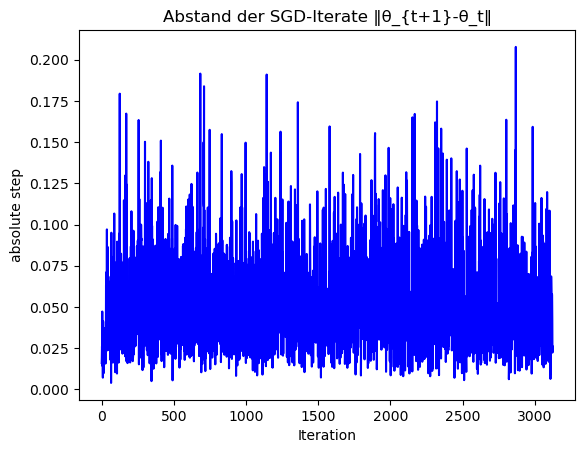

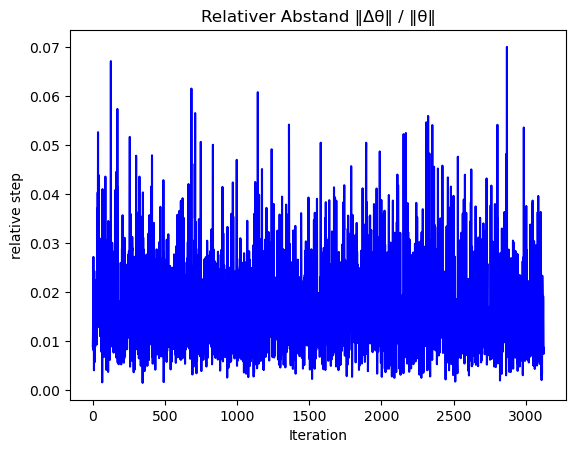

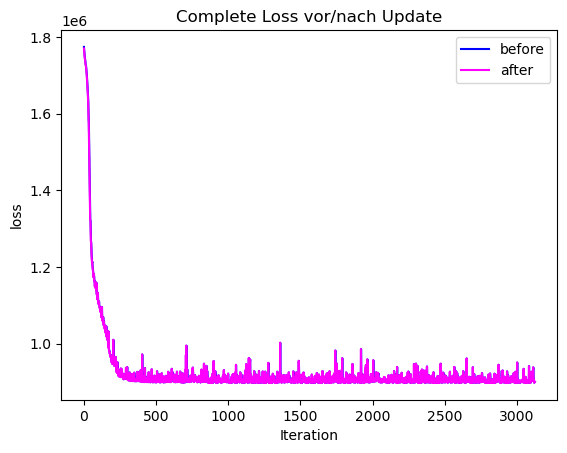

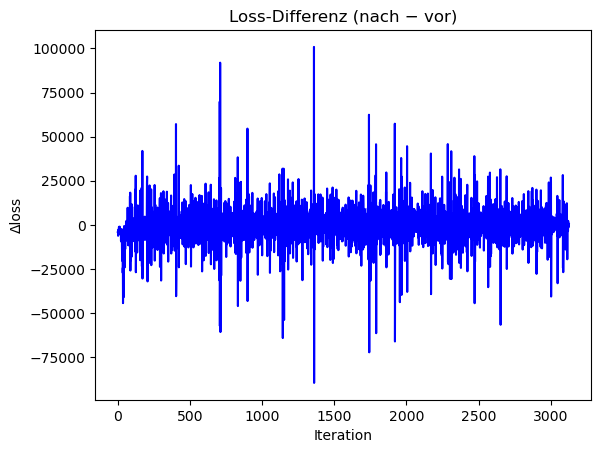

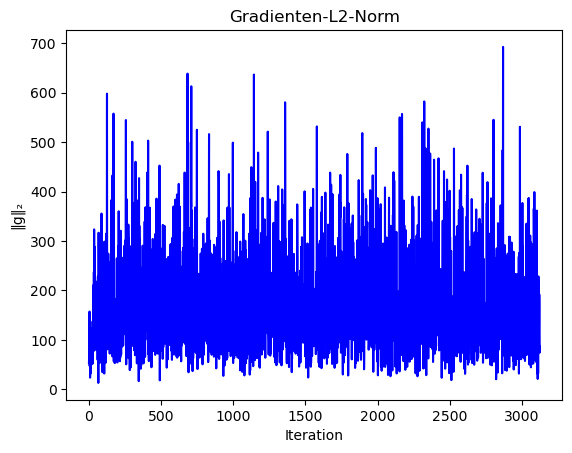

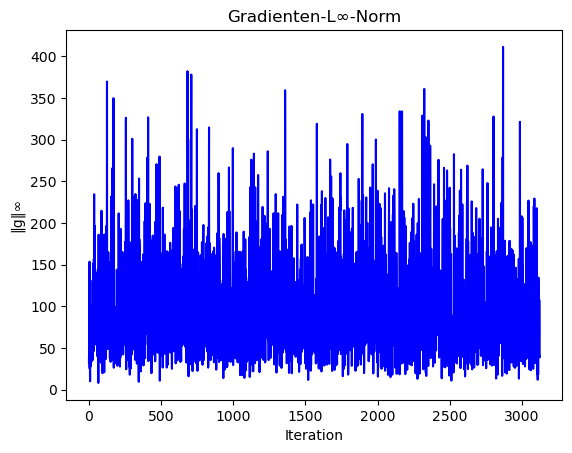

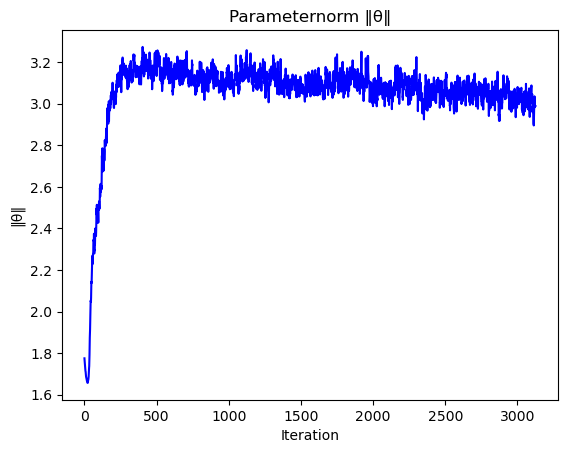

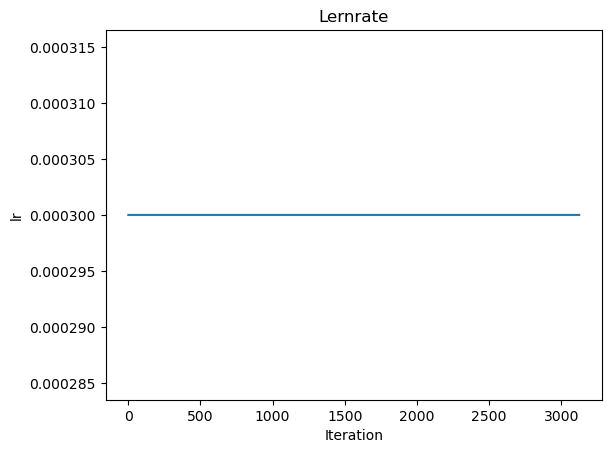

Final Loss(θ0): 1774324.125
Final Loss(θ*): 900821.0625
Absolute Final Error Reduction: -873503.0625
Relative Final Error Reduction: -49.23%


In [5]:
#Optimize model with sgd
θ0 = model.get_θ()

training_dataset = list(zip(X,Y))

θK, θ_iterates, grad_iterates = stochastic_gradient_descent(model, θ0, training_dataset, rss, η5, b, plot=True)

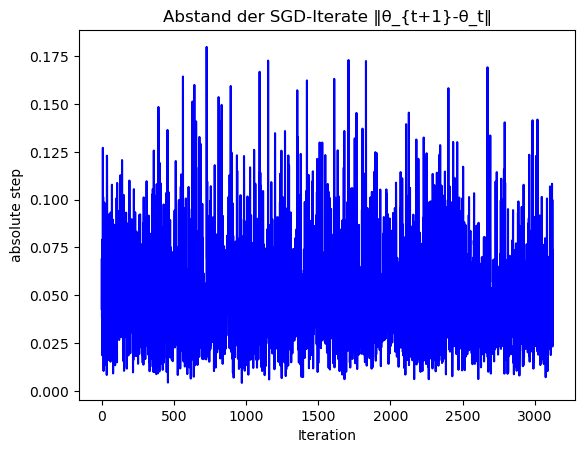

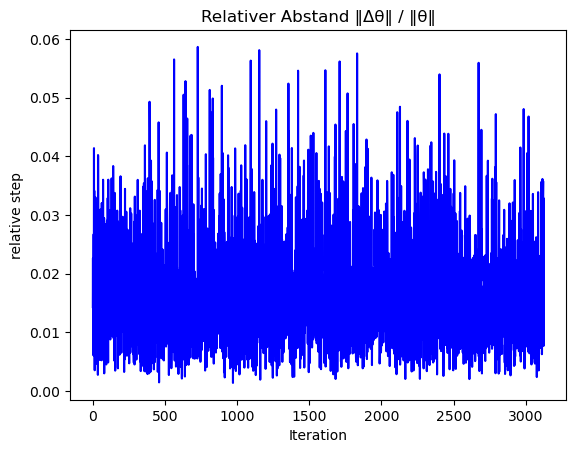

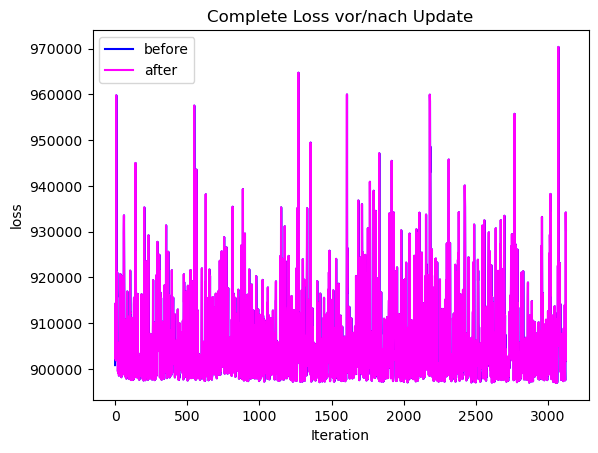

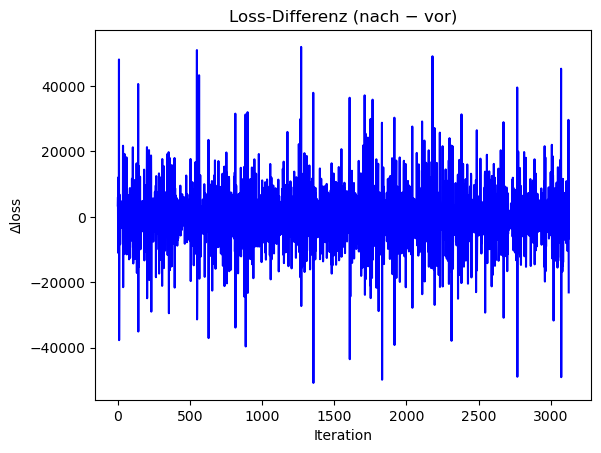

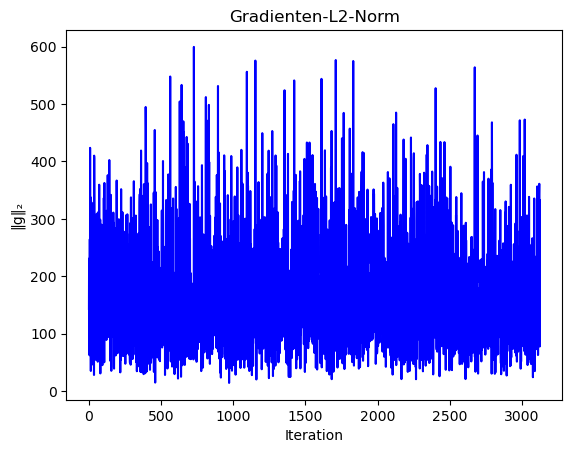

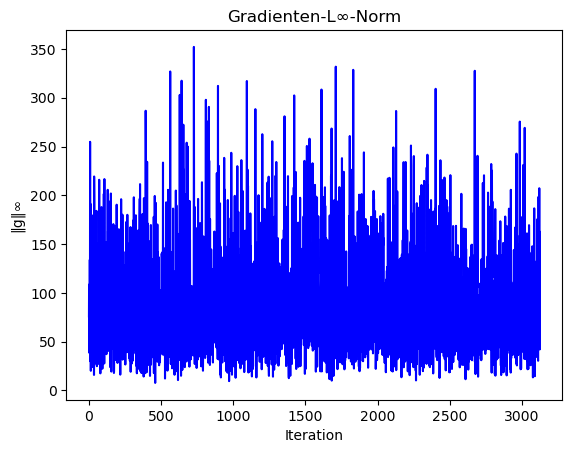

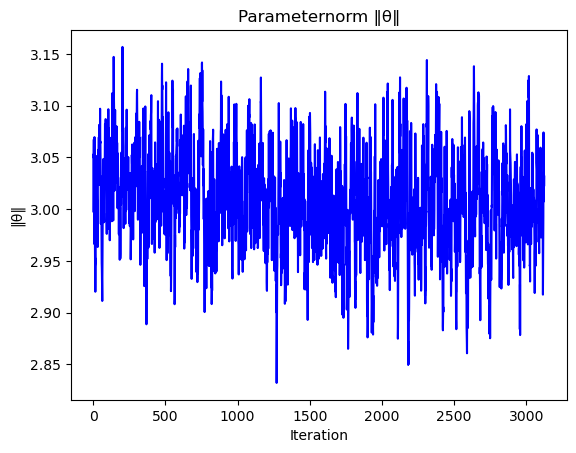

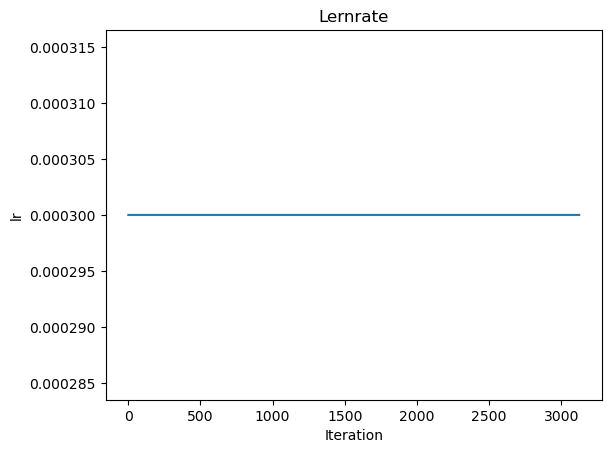

Final Loss(θ0): 900821.0625
Final Loss(θ*): 907220.3125
Absolute Final Error Reduction: 6399.25
Relative Final Error Reduction: 0.71%


In [7]:
# Start the SGD out of the attractor θK
θK2, θ_iterates, grad_iterates = stochastic_gradient_descent(model, θK, training_dataset, rss, η5, b, plot=True)

In [28]:
#Calculate the fluctuations around the attractor θK

"""
Utility function that takes two Tensors 
and returns the component wise subtraction.
"""
def subtract_weights(weightsk: List[torch.Tensor], weightsK: List[torch.Tensor]) -> List[torch.Tensor]:
    if len(weightsk) != len(weightsK):
        raise ValueError("Tensors have different lengths.")
    return [weightk - weightK for weightk, weightK in zip(weightsk, weightsK)]

with torch.no_grad():
    ξ_iterates = [subtract_weights(θ, θK) for θ in θ_iterates]    


In [72]:
#Calculate the Eigenvalues of the Hessian Matrix in the Attractor θK via the Power 
#Iteration Method

"""
Utility function that flattens a given tensor. 
"""
def _flatten(tlist: List[torch.Tensor]) -> torch.Tensor:
    return torch.cat([t.reshape(-1) for t in tlist])

"""
Utility function that normalizes a vector. 
"""
def _normalize(v):
    nrm = _flatten(v).norm()
    return [p / (nrm + 1e-12) for p in v]

"""
Converts the input X to the forecast of the model.
The model uses the configuration, that is given with θ.
"""
def forecast(model, X, θ):
    idx = 0
    out = X
    for module in model.net:
        if isinstance(module, nn.Linear):
            W = θ[idx]
            bias = θ[idx + 1]
            out = out @ W.T + bias
            idx += 2
        else:
            out = module(out)
    return out

"""
Calculates the loss for given θ.
The type of loss function varies with the given X,Y.
If X,Y is the whole training dataset -> empirical population risk.
If X,Y is just a custom Batch of the training dataset -> batch loss.
"""
def loss_function(model, θ, X, Y, loss):
    Y_hat = forecast(model, X, θ)
    return float(loss(Y_hat, Y).detach())

"""
Calculates the Gradient loss for a given θ.
The type of loss function varies with the given X,Y.
If X,Y is the whole training dataset -> gradient of the empirical population risk.
If X,Y is just a custom Batch of the training dataset -> batch gradient.
"""
def loss_function_grad(model, θ, X, Y, loss):
    θ_diff = [p.clone().detach().requires_grad_(True) for p in θ]
    Y_hat = forecast(model, X, θ_diff)
    loss_val = loss(Y_hat, Y)
    loss_val.backward()
    grads = [p.grad for p in θ_diff]
    return grads

"""
Linear Transformation H@v for a vector v.
enables use of Matrix Product with the hessian 
without calculating the Hessian Matrix itself.
"""
def hessian_vector_product(model, θ: List[torch.Tensor], X, Y, v):
    θ_diff = [p.clone().detach().requires_grad_(True) for p in θ]
    Y_hat = forecast(model, X, θ_diff)
    loss_val = rss(Y_hat, Y)

    grads = torch.autograd.grad(
        outputs=loss_val,
        inputs=θ_diff,
        create_graph=True,   
        retain_graph=True,  
        allow_unused=False
    )

    dot = sum((g * vi).sum() for g, vi in zip(grads, v))

    hvp = torch.autograd.grad(
        outputs=dot,
        inputs=θ_diff,
        retain_graph=False,  
        allow_unused=False
    )

    return hvp

def rayleigh_quotient(v: torch.Tensor, hvp: List[torch.Tensor]):
    v_flat = _flatten(v) if isinstance(v, list) else v.reshape(-1)
    hvp_flat = _flatten(hvp) if isinstance(hvp, (list, tuple)) else hvp.reshape(-1)
    return (torch.dot(v_flat, hvp_flat) / torch.dot(v_flat, v_flat))

"""
Algorithm that approximates the biggest Eigenvalue of the Hessian Matrix 
of the Empirical Population Risk on a given θ.
"""
def power_iteration_method(model, θ: List[torch.Tensor], tolerance: float):
    v = [torch.randn_like(p) for p in θ]
    v = _normalize(v)

    λ_old = None

    X_full = torch.stack([x for x, y in training_dataset])
    Y_full = torch.stack([y for x, y in training_dataset])

    while True:
        hvp = hessian_vector_product(model, θ, X_full, Y_full, v)

        λ = rayleigh_quotient(v, hvp).item()

        if λ_old is not None:
            if abs(λ - λ_old) < tolerance:
                break

        v = _normalize(list(hvp))
        λ_old = λ
        
    return λ, v

λ, v_max = power_iteration_method(model, θK, 1e-5)